Iteration 0: Best MSE = 16941.1663
Iteration 10: Best MSE = 16822.5890
Iteration 20: Best MSE = 16788.2425
Iteration 30: Best MSE = 16780.6214
Iteration 40: Best MSE = 16755.0301
Iteration 50: Best MSE = 16755.0301
Iteration 60: Best MSE = 16755.0301
Iteration 70: Best MSE = 16755.0301
Iteration 80: Best MSE = 16755.0301
Iteration 90: Best MSE = 16755.0301

Best Parameters: [ 1.15789474 -0.52631579  0.73684211  0.31578947  2.        ]

ACO Linear Regressor (raw a,b,c,d):
  Test MSE: 15248.3480
  Test R²: -2.1293


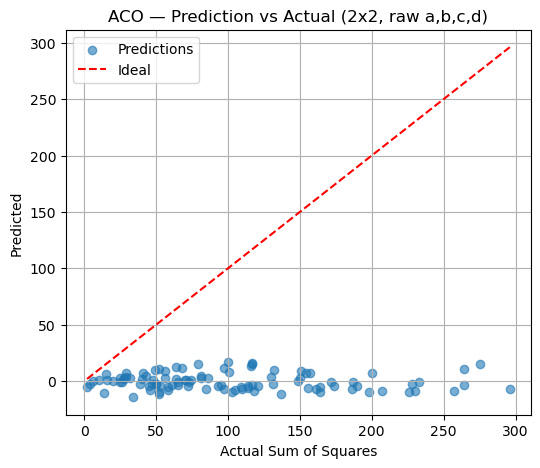

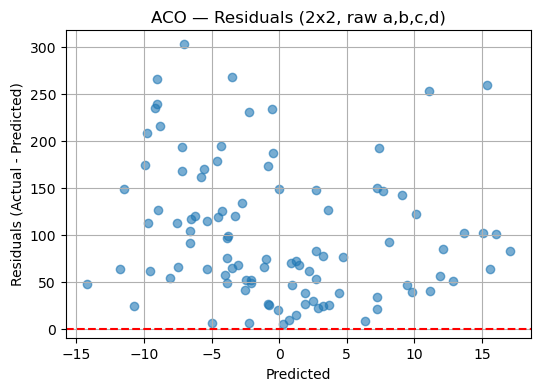

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

train_df = pd.read_csv("train_eigen_data.csv")
test_df  = pd.read_csv("test_eigen_data.csv")

X_train = train_df[['a', 'b', 'c', 'd']].values
y_train = train_df['sum_squared'].values
X_test  = test_df[['a', 'b', 'c', 'd']].values
y_test  = test_df['sum_squared'].values

n_features = X_train.shape[1]
n_params = n_features + 1  
n_ants = 40
n_iterations = 100
alpha = 1.0    
beta = 2.0     
rho = 0.2      

param_min, param_max = -2.0, 2.0

def fitness(params):
    weights = params[:-1]
    bias = params[-1]
    preds = X_train @ weights + bias
    return mean_squared_error(y_train, preds)


pheromone = np.ones((n_params, 20))  
param_values = [np.linspace(param_min, param_max, 20) for _ in range(n_params)]

best_params = None
best_score = float("inf")

for it in range(n_iterations):
    ants_params = []
    ants_scores = []

    for ant in range(n_ants):
        params = []
        for i in range(n_params):
            probs = pheromone[i] ** alpha
            probs /= probs.sum()
            choice = np.random.choice(len(param_values[i]), p=probs)
            params.append(param_values[i][choice])
        params = np.array(params)

        score = fitness(params)
        ants_params.append(params)
        ants_scores.append(score)

        if score < best_score:
            best_score = score
            best_params = params

    pheromone = (1 - rho) * pheromone
    for i in range(n_params):
        for ant_idx, params in enumerate(ants_params):
            val = params[i]
            j = np.argmin(np.abs(param_values[i] - val))
            pheromone[i][j] += 1.0 / (1.0 + ants_scores[ant_idx])

    if it % 10 == 0:
        print(f"Iteration {it}: Best MSE = {best_score:.4f}")

print("\nBest Parameters:", best_params)

weights = best_params[:-1]
bias = best_params[-1]
y_pred = X_test @ weights + bias

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"\nACO Linear Regressor (raw a,b,c,d):")
print(f"  Test MSE: {mse:.4f}")
print(f"  Test R²: {r2:.4f}")

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label="Ideal")
plt.xlabel("Actual Sum of Squares")
plt.ylabel("Predicted")
plt.title("ACO — Prediction vs Actual (2x2, raw a,b,c,d)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("ACO — Residuals (2x2, raw a,b,c,d)")
plt.grid(True)
plt.show()


Sanity check: train data matches exact formula (trace^2 - 2*det).
Sanity check: test data matches exact formula (trace^2 - 2*det).
Iter 1/10000  best_train_MSE=3275.281212
Iter 51/10000  best_train_MSE=3275.027592
Iter 101/10000  best_train_MSE=3275.027592
Iter 151/10000  best_train_MSE=3275.027592
Iter 201/10000  best_train_MSE=3275.009692
Iter 251/10000  best_train_MSE=3274.994464
Iter 301/10000  best_train_MSE=3274.984668
Iter 351/10000  best_train_MSE=3274.970800
Iter 401/10000  best_train_MSE=3274.966846
Iter 451/10000  best_train_MSE=3274.966846
Iter 501/10000  best_train_MSE=3274.959678
Iter 551/10000  best_train_MSE=3274.954415
Iter 601/10000  best_train_MSE=3274.954415
Iter 651/10000  best_train_MSE=3274.954270
Iter 701/10000  best_train_MSE=3274.954270
Iter 751/10000  best_train_MSE=3274.952738
Iter 801/10000  best_train_MSE=3274.951791
Iter 851/10000  best_train_MSE=3274.951164
Iter 901/10000  best_train_MSE=3274.951164
Iter 951/10000  best_train_MSE=3274.950939
Iter 1001/10

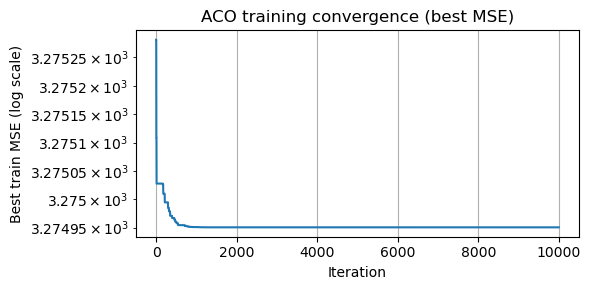

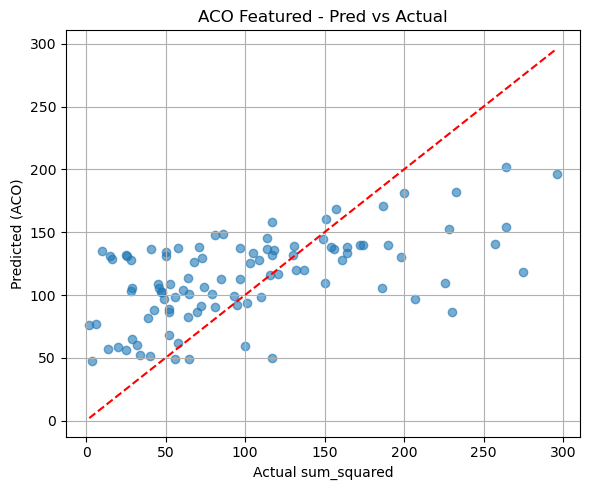

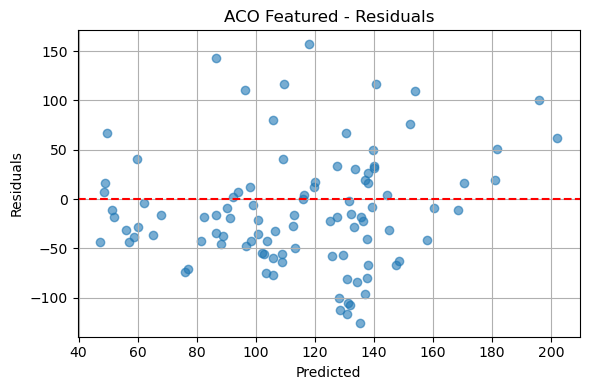

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

TRAIN_CSV = "train_eigen_data.csv"
TEST_CSV  = "test_eigen_data.csv"
OUT_CSV   = "test_eigen_data_aco_featured_preds.csv"
RANDOM_SEED = 42

N_ANTS = 2000
N_ITER = 10000
TOP_K = 20           
LR = 0.25            
SIGMA_INIT = 1.0     
SIGMA_DECAY = 0.997  
MIN_SIGMA = 1e-6
VERBOSE = True


def add_features(df):
    df = df.copy()
    df['trace'] = df['a'] + df['d']
    df['det'] = df['a'] * df['d'] - df['b'] * df['c']
    df['sym_score'] = np.abs(df['b'] - df['c'])
    return df

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_df = add_features(train_df)
test_df  = add_features(test_df)

features = ['a', 'b', 'c', 'd', 'trace', 'det', 'sym_score']

for col in features + ['sum_squared']:
    if col not in train_df.columns:
        raise ValueError(f"Missing column in train CSV: {col}")
    if col not in test_df.columns and col != 'sum_squared':
        raise ValueError(f"Missing column in test CSV: {col}")

X_train_raw = train_df[features].values.astype(float)
y_train = train_df['sum_squared'].values.astype(float)
X_test_raw = test_df[features].values.astype(float)
y_test = test_df['sum_squared'].values.astype(float)

trace_sq_train = train_df['trace'].values**2
det_train = train_df['det'].values
if np.allclose(trace_sq_train - 2*det_train, y_train, atol=1e-8):
    print("Sanity check: train data matches exact formula (trace^2 - 2*det).")
else:
    print("Warning: train data does NOT exactly match trace^2 - 2*det (there may be noise or rounding).")
trace_sq_test = test_df['trace'].values**2
det_test = test_df['det'].values
if np.allclose(trace_sq_test - 2*det_test, y_test, atol=1e-8):
    print("Sanity check: test data matches exact formula (trace^2 - 2*det).")
else:
    print("Warning: test data does NOT exactly match trace^2 - 2*det (there may be noise or rounding).")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

n_features = X_train.shape[1]        
n_params = n_features + 1            


class ACORegressorFeatured:
    def __init__(self, n_ants=200, n_iter=1000, top_k=20, lr=0.25,
                 sigma_init=1.0, sigma_decay=0.997, min_sigma=1e-6,
                 random_state=None, verbose=True):
        self.n_ants = n_ants
        self.n_iter = n_iter
        self.top_k = top_k
        self.lr = lr
        self.sigma_init = sigma_init
        self.sigma_decay = sigma_decay
        self.min_sigma = min_sigma
        self.random_state = random_state
        self.verbose = verbose

    def _evaluate_population(self, X, y, population):
        W = population[:, :-1]   
        b = population[:, -1]    
        preds = X.dot(W.T) + b.reshape(1, -1)
        mse = np.mean((preds - y.reshape(-1, 1))**2, axis=0)  
        return mse

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)

        A = np.hstack([X, np.ones((X.shape[0], 1))])
        try:
            w0, *_ = np.linalg.lstsq(A, y, rcond=None)
            mu = w0.copy()   
        except Exception:
            mu = np.zeros(n_params)

        sigma = np.ones(n_params) * self.sigma_init
        best_loss = np.inf
        best_params = mu.copy()

        history = []
        for it in range(self.n_iter):
            population = rng.normal(loc=mu, scale=sigma, size=(self.n_ants, n_params))

            mse = self._evaluate_population(X, y, population)

            sorted_idx = np.argsort(mse)
            top_idx = sorted_idx[:self.top_k]
            top_pop = population[top_idx]
            top_mse = mse[top_idx]

            weights_inv = 1.0 / (top_mse + 1e-12)
            weights_norm = weights_inv / weights_inv.sum()
            elite_mean = (weights_norm.reshape(-1,1) * top_pop).sum(axis=0)

            mu = (1.0 - self.lr) * mu + self.lr * elite_mean

            sigma = np.maximum(sigma * self.sigma_decay, self.min_sigma)

            if mse[sorted_idx[0]] < best_loss:
                best_loss = float(mse[sorted_idx[0]])
                best_params = population[sorted_idx[0]].copy()

            history.append(best_loss)
            if self.verbose and (it % 50 == 0 or it == self.n_iter - 1):
                print(f"Iter {it+1}/{self.n_iter}  best_train_MSE={best_loss:.6f}")

        self.mu_ = mu
        self.sigma_ = sigma
        self.best_params_ = best_params
        self.best_loss_ = best_loss
        self.history_ = np.array(history)
        return self

    def predict(self, X):
        w = self.best_params_[:-1]
        b = self.best_params_[-1]
        return X.dot(w) + b

aco = ACORegressorFeatured(
    n_ants=N_ANTS, n_iter=N_ITER, top_k=TOP_K, lr=LR,
    sigma_init=SIGMA_INIT, sigma_decay=SIGMA_DECAY,
    min_sigma=MIN_SIGMA, random_state=RANDOM_SEED, verbose=VERBOSE
)

aco.fit(X_train, y_train)

y_pred = aco.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("\nFinal Test results (ACO Featured):")
print(f"  Test MSE: {mse_test:.6f}")
print(f"  Test R² : {r2_test:.6f}")
print(f"  Best train MSE found: {aco.best_loss_:.6f}")

test_df_out = test_df.copy()
test_df_out['predicted_sum_squared_aco'] = y_pred
test_df_out.to_csv(OUT_CSV, index=False)
print(f"Predictions saved to: {OUT_CSV}")

plt.figure(figsize=(6,3))
plt.plot(aco.history_)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Best train MSE (log scale)")
plt.title("ACO training convergence (best MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Actual sum_squared")
plt.ylabel("Predicted (ACO)")
plt.title("ACO Featured - Pred vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("ACO Featured - Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()
